### Import modules

In [67]:
import networkx as nx
import graph_bandit_RL
from graph_bandit_helper_tools import *
import numpy as np
from known_rewards_helper_functions import get_Q_table
from estimator import NormalBayesianEstimator
from tqdm import trange
from functools import partial

import pickle as pkl

%load_ext autoreload
%autoreload 2

SEED = 181731

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Our algorithm

In [68]:
def visit_all_nodes(gb):
    while True:
        unvisited = [i for i in range(n_nodes) if gb.visits[i]==0]

        if len(unvisited)==0:
            break

        dest = unvisited[0]

        next_path = nx.shortest_path(gb.G,gb.state,dest)
        for s in next_path[1:]:
            gb.step(s)

def get_ucb(gb,nodes=None):
    
    if nodes is None:
        nodes = gb.nodes
    ave_reward = [np.mean(gb.nodes[i]['r_hist']) for i in nodes] 
    nm = [gb.visits[i] for i in nodes]
    
    tm = len(gb.visitedStates)
    ucb = ave_reward + np.sqrt(2*np.log(tm)/nm)
    
    return ucb


def get_ucb_Q_table(gb):
     
    ucb = get_ucb(gb)
    
    gap = np.sort(list(set(ucb)))[-1]-np.sort(list(set(ucb)))[-2]

    TG = nx.diameter(gb.G)*np.max(ucb)/gap

    Q,k, _ = get_Q_table(gb.G,ucb,TG)
    return Q


def train_agent(n_samples,T,G,means, stdevs,init_node,execute_agent):
    regrets = np.zeros((n_samples,T))
    for i in trange(n_samples):

        env = graph_bandit_RL.GraphBandit(means[i], stdevs[i], G)

        ## Visit all nodes
        visit_all_nodes(env)

        H0 = len(env.visitedStates)

        # Start learning

        env.state = init_node

        while len(env.visitedStates)-H0<T:
            execute_agent(env)
            
        # print(env.visitedStates.shape,regrets.shape)
            
        regrets[i,:]= env.expectedRegret()[:T]
        
    return regrets

In [69]:
def doubling_agent(env):
    ucb = get_ucb(env)
    # Compute Q table.
    Q = get_ucb_Q_table(env)

    # Travel to the node with the highest UCB
    while ucb[env.state] < np.max(ucb):
        next_s = np.argmax(Q[env.state,:])
        env.step(next_s)

    target_count = 0+env.nodes[env.state]['n_visits']
    # Keep sampling the best UCB node until its number of samples doubles
    for _ in range(target_count):
        env.step(env.state)

def local_ucb_agent(env):
    neighbors = [_ for _ in env.G[env.state]]

    neighbor_ucb = get_ucb(env,neighbors)

    best_nb = neighbors[np.argmax(neighbor_ucb)]

    env.step(best_nb)

def local_ts_agent(env,
                    var_0 = 0.5,
                    mu_0 = 5,
                    var = 0.5):

    neighbors = [_ for _ in env.G[env.state]]
    

    # Bayesian estimation of mu and var estimation with Gaussian Prior

    xsum = np.array([np.sum(env.nodes[i]['r_hist']) for i in neighbors])
    n = np.array([env.visits[i] for i in neighbors])

    var_1 = 1/(var_0 + n/var) 
    mu_1 = var_1 * (mu_0/var_0 + xsum/var)

    # Posterior sampling
    mu_sample = np.random.normal(mu_1,np.sqrt(var_1))

    
    # Take a step in the environment
    best_nb = neighbors[np.argmax(mu_sample)]
    env.step(best_nb)
    
def local_greedy_agent(env,
                    epsilon0=1,var_0 = 0.5,
                    mu_0 = 5,
                    var = 0.5):

    neighbors = [_ for _ in env.G[env.state]]
    
    # epsilon = epsilon0 / (len(env.visitedStates)+1)
    epsilon = epsilon0
    
    if np.random.rand()<epsilon:
        env.step(np.random.choice(neighbors))
    else:
         # Bayesian estimation of mu and var estimation with Gaussian Prior

        xsum = np.array([np.sum(env.nodes[i]['r_hist']) for i in neighbors])
        n = np.array([env.visits[i] for i in neighbors])

        var_1 = 1/(var_0 + n/var) 
        mu_1 = var_1 * (mu_0/var_0 + xsum/var)
        
        # Take a step in the environment
        best_nb = neighbors[np.argmax(mu_1)]
        env.step(best_nb)

In [70]:
def plotRegrets(allRegrets, titles=None, save_fig=None):
    """
    param allRegrets: list of dictionaries of regrets(samples, time_steps) for various algorithms and runs
    """
    nPlots = len(allRegrets)
    sns.set()
    
    labels = {'greedy': 'Local $\epsilon$-greedy', 'thompson': 'Local TS', 'UCB': 'Local UCB','Q_learning': 'Q-learning',\
              'Our Algorithm':'Our Algorithm'}
    styles = {'greedy': 'dashed', 'thompson': 'dashed', 'UCB': 'dashed','Q_learning': 'dotted',\
              'Our Algorithm':'solid'}
    colors = {'greedy': 'b', 'thompson': 'r', 'UCB': 'g','Q_learning': 'r',\
              'Our Algorithm':'k'}
    keys = allRegrets[0].keys()
    

    if nPlots == 1:
        regrets = allRegrets[0]
        for i, key in enumerate(keys):
            regret = regrets[key]
            regret = np.cumsum(regret, axis=1)
            regret = np.mean(regret, axis=0)
            plt.plot([i for i in range(1,len(regret)+1)],regret, c=colors[key], linestyle = styles[key], label=labels[key],\
                    linewidth=3)
        if titles is not None:    
            plt.title(titles[0])
    else:
        fig, axes = plt.subplots(2, 3, figsize=(17,10))
        for j, regrets in enumerate(allRegrets):
            for i, key in enumerate(regrets.keys()):
                regret = regrets[key]
                regret = np.cumsum(regret, axis=1)
                df = pd.DataFrame(np.transpose(regret))
                df.columns = [labels[key] for _ in range(regret.shape[0])]
                if j<3:
                    sns.lineplot(ax = axes[0,j], data=df, ci=None, palette=[colors[key]])
                    axes[0,j].set_title(titles[j])
                else:
                    sns.lineplot(ax = axes[1,j%3], data=df, ci=None, palette=[colors[key]])
                    axes[1,j%3].set_title(titles[j])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.45), fontsize=16)
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('Expected regret', fontsize=20)
    plt.tick_params(labelsize=20)
    plt.style.use('seaborn-dark-palette')
    if save_fig is not None:
        plt.savefig('Figures/'+save_fig, bbox_inches = 'tight')
    plt.show()

<>:8: DeprecationWarning: invalid escape sequence \e


### Define parameters

Define the following parameters:  
$\texttt{T}:$ game length  
$\texttt{n_samples}:$ number of games to run   
$\texttt{episodes}:$ number of episodes; Let this be 1 for now 
$\texttt{n_nodes}:$ number of nodes in graph. 
$\texttt{mu_size}:$ the node means are drawn as $\mu\sim \texttt{mu_size}\times \mathcal{N}(0,1)$   
$\texttt{sigma_size}:$ the node standard deviations are set to $\texttt{sigma_size}$ 
$\texttt{epsilon}:$ exploration parameter (only applicable for Q-learning algorithms)  
$\texttt{epsilon_discount}:$ exploration discount parameter (only applicable for Q-learning algorithms)  
$\texttt{algorithms}:$ the algorithms to run. 


 



In [105]:
n_samples = 100
episodes = 1
n_nodes = 10
mu_size = 1
sigma_size = 1

# For Q-learning

epsilon = 0.9
epsilon_discount=0.99

init_node = 0

# Line graph

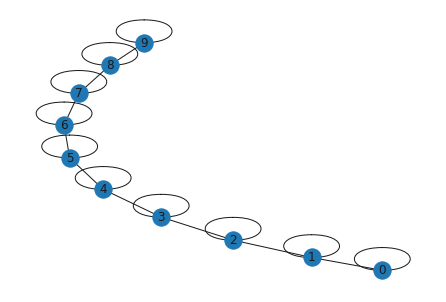

In [122]:
T = 1200

np.random.seed(SEED)
n_nodes = 10
G = return_graph('line', n_nodes)
draw_graph(G)

In [123]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

In [124]:
line_regrets = {}

In [125]:

# line_regrets['greedy'] = train_agent(n_samples,T,G,means, stdevs,init_node,partial(local_greedy_agent,epsilon0=0.05))

line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


In [126]:
# epsilon = epsilon0*epsilon_discount**h

reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})

line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


In [127]:
line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.80it/s]


In [131]:
with open('Data/line.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)

/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


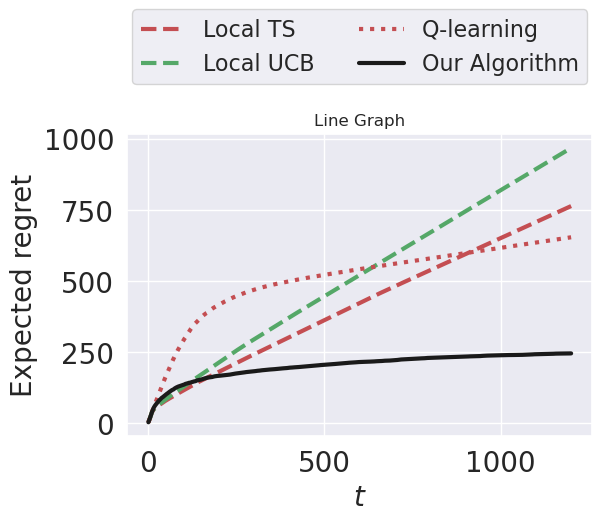

In [128]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Line Graph'])

# Circle graph

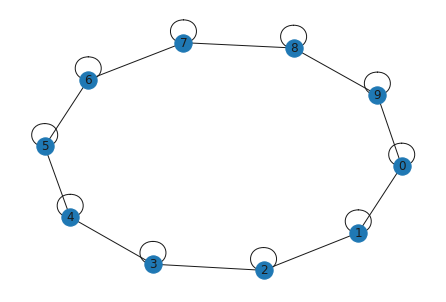

In [169]:
T = 2000

np.random.seed(SEED)
n_nodes = 10
G = return_graph('circle', n_nodes)
draw_graph(G)

In [170]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

In [171]:
line_regrets = {}

In [172]:

# line_regrets['greedy'] = train_agent(n_samples,T,G,means, stdevs,init_node,partial(local_greedy_agent,epsilon0=0.05))

line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


In [173]:
# epsilon = epsilon0* 0.99**h

reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=0.99,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})

line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


In [174]:
line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.40it/s]


In [177]:
with open('Data/circle.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)

/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


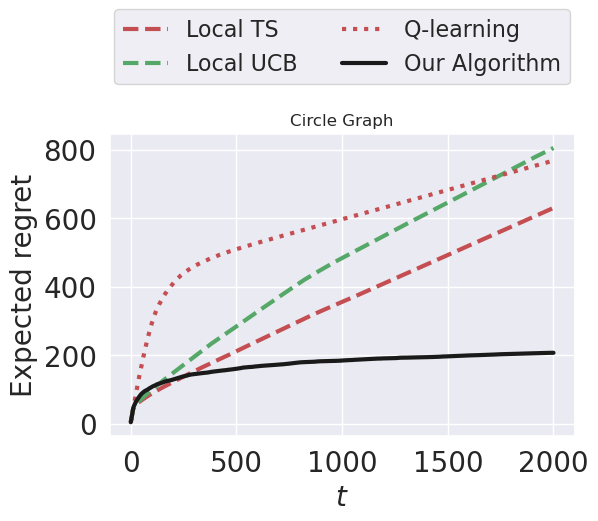

In [176]:

plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Circle Graph'])

# Tree graph

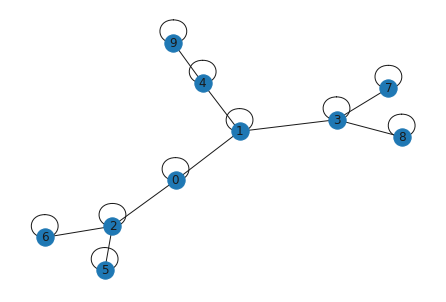

In [215]:
T = 1500

np.random.seed(SEED)
n_nodes = 10
G = return_graph('tree', n_nodes,n_children = 2)
draw_graph(G)

In [216]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

In [217]:
line_regrets = {}

In [218]:

line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


In [220]:
# epsilon = epsilon0* 0.99**h
reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})

line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


In [221]:
line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


In [222]:
with open('Data/tree.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)

/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


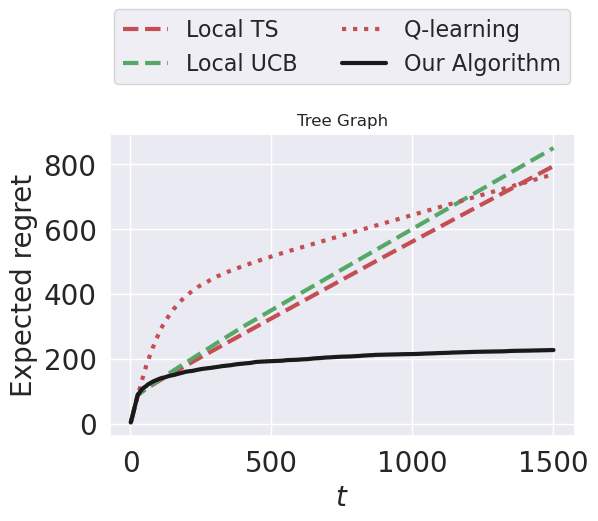

In [223]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Tree Graph'])

# Grid graph

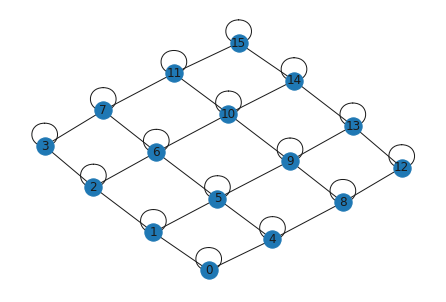

In [261]:
T = 1000

np.random.seed(SEED)
n_nodes = 16
G = return_graph('maze')
draw_graph(G)

In [262]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

In [263]:
line_regrets = {}

In [264]:

line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


In [265]:
reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})

line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


In [266]:
line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.56it/s]


In [267]:
with open('Data/grid.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)

/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


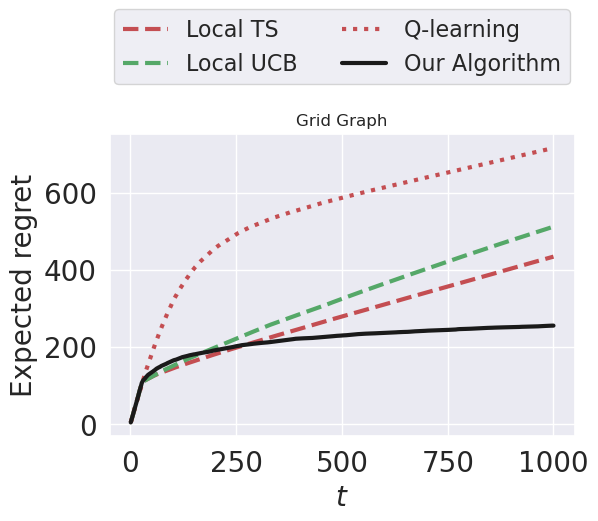

In [268]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Grid Graph'])

# Star graph

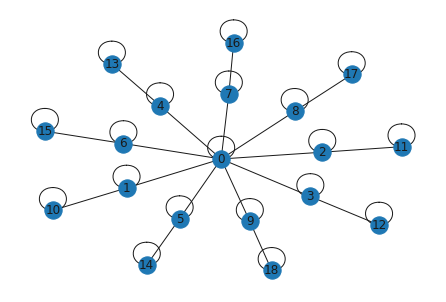

In [253]:
T = 1200

np.random.seed(SEED)


n_branches = 9
n_layers = 2

G = nx.Graph()

G.add_edge(0,0)
for l in range(n_layers):
    for b in range(n_branches):
        G.add_edge(max(b+1+(l-1)*n_branches,0),b+1+l*n_branches)

for i in G.nodes:
    G.add_edge(i,i)
    
# G = return_graph('star',10)
draw_graph(G)

n_nodes = G.number_of_nodes()

In [254]:
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,G.number_of_nodes()))
stdevs = np.ones((n_samples,G.number_of_nodes()))

In [255]:
line_regrets = {}

In [256]:

line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


In [257]:
reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})

line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


In [258]:
line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.71it/s]


In [259]:
with open('Data/star.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)

/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


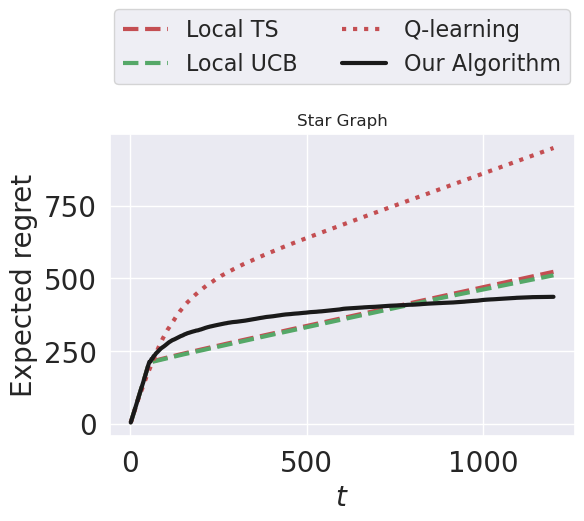

In [260]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Star Graph'])

# Fully connected graph

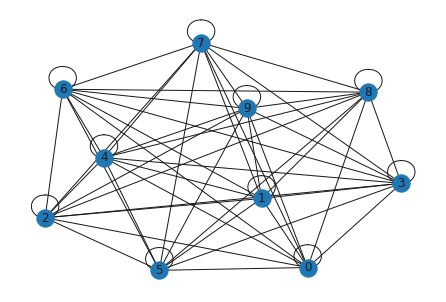

In [247]:
T = 1000
np.random.seed(SEED)
n_nodes = 10
G = return_graph('fully_connected', n_nodes)
draw_graph(G)

In [248]:
# means = np.random.normal(size=(n_samples,n_nodes))
np.random.seed(SEED)
means = np.random.uniform(low=0.5,high=9.5,size=(n_samples,n_nodes))
stdevs = np.ones((n_samples,n_nodes))

In [249]:
line_regrets = {}

line_regrets['Our Algorithm'] = train_agent(n_samples,T,G,means, stdevs,init_node,doubling_agent)

line_regrets['UCB'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ucb_agent)


line_regrets['thompson'] = train_agent(n_samples,T,G,means, stdevs,init_node,local_ts_agent)



100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]


In [250]:
#  epsilon = 0.7*(3*self.num_nodes + 1) / (3*self.num_nodes + h)
reg,_=testLearning(episodes=episodes, T=T, n_samples=n_samples, epsilon=epsilon,\
                          epsilon_discount=epsilon_discount,\
                          algorithms=['Q_learning'], G=G, means=means, stdevs=stdevs, mean_magnitude=mu_size,\
                          stdev_magnitude=sigma_size, update_multiple_qs=True,init_nodes = {'Q_learning':init_node})



line_regrets['Q_learning'] = reg['Q_learning']

100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/tianpeng/miniconda3/envs/main/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


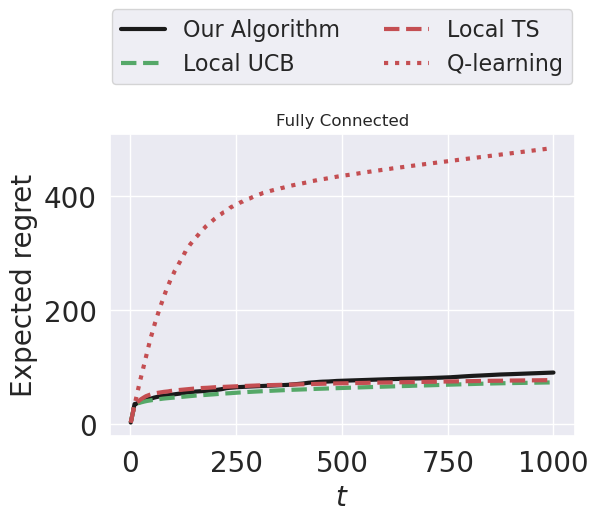

In [251]:
plt.figure(dpi=100)

plotRegrets([line_regrets], titles=['Fully Connected'])

In [252]:
with open('Data/fully-connected.pkl', 'wb') as file:
    pkl.dump(line_regrets,file)